In [120]:
from timeit import default_timer as timer
start = timer()

In [121]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.datasets import cifar10 as cf10



import matplotlib.pylab as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [122]:
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.11.1


In [123]:
# Load image data from CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cf10.load_data()

In [124]:
# Define helper function to view images
def show_images(train_images,class_names,train_labels,nb_samples=12, nb_row=4):
    plt.figure(figsize=(12,12))
    for i in range(nb_samples):
        plt.subplot(nb_row,nb_row,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i],cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[i][0]])
    plt.show()
    

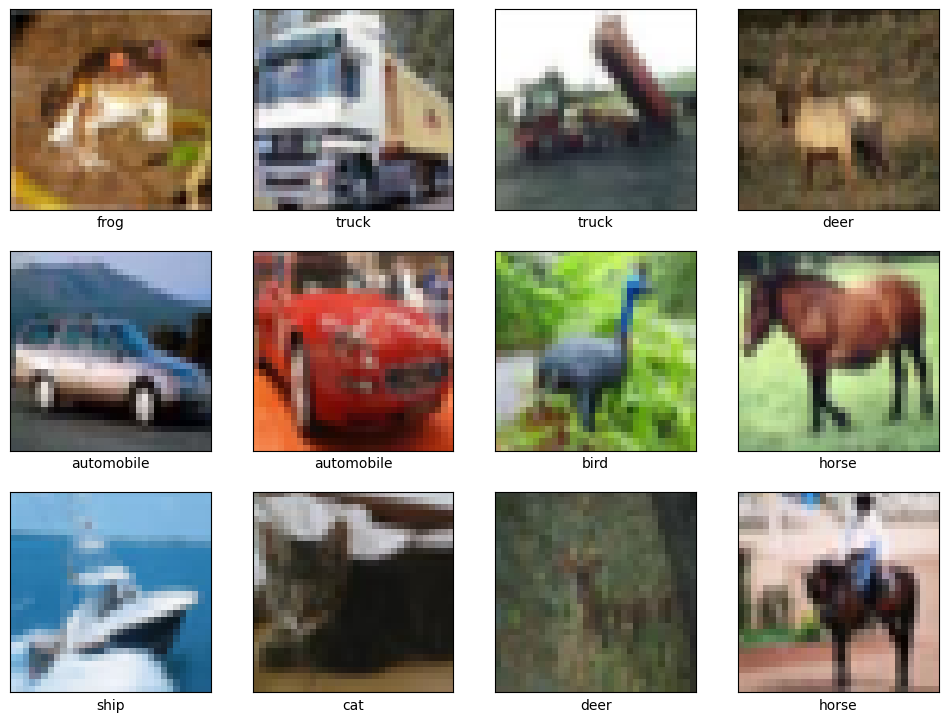

In [125]:
#Show samples images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog','frog','horse','ship','truck']
show_images(train_images, class_names,train_labels)

In [126]:
#preprocess training and testing images using MobileNetV2 preprocessor
#train_images = tf.keras.applications.mobilenet_v2.preprocess_input(train_images)
#test_images = tf.keras.applications.mobilenet_v2.preprocess_input(test_images)

# convert labels from text to one-hot vectors
train_labels = tf.keras.utils.to_categorical(train_labels, len(class_names))
test_labels = tf.keras.utils.to_categorical(test_labels, len(class_names))

In [127]:
# define the transfer model
INPUT_SHAPE = (32,32,3)
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3,3)
POOL_SHAPE = (2,2)
FULLY_CONNECT_NUM = 1024
NUM_CLASSES = len(class_names)
MAX_PIXEL_SIZE = 255

base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=NUM_CLASSES)
#base_model.trainable = False

inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = tfl.Rescaling(1.0/MAX_PIXEL_SIZE)(inputs)
x = tfl.RandomFlip('horizontal')(x)

#x = base_model(inputs, training = False)
x = base_model(x)

#x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(0.5)(x)
x = tfl.Flatten()(x)

x = tfl.Dense(512,activation='relu')(x)
#x = tfl.Dropout(0.2)(x)

x = tfl.Dense(256,activation='relu')(x)
x = tfl.Dropout(0.3)(x)

x = tfl.Dense(128,activation='relu')(x)
x = tfl.Dropout(0.2)(x)

outputs = tfl.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 1, 1, 1024)        0         
                                                                 
 flatten_6 (Flatten)         (None, 1024)              0         
                                                           

In [128]:
#Model compiling

BATCH_SIZE = 128
EPOCHS = 20
# METRICS = ['accuracy',
#            tf.keras.metrics.Precision(name='precision'),
#            tf.keras.metrics.Recall(name='recall')
#            ]

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
#               loss='categorical_crossentropy',
#               metrics=METRICS)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics='accuracy')


In [129]:
# model training

training_history = model.fit(x=train_images,
                             y=train_labels,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE,
                             validation_data=(test_images, test_labels))


Epoch 1/20


2023-10-13 19:09:53.225749: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


391/391 [==============================] - 71s 145ms/step - loss: 1.3174 - accuracy: 0.5529 - val_loss: 0.9303 - val_accuracy: 0.6847
Epoch 2/20
391/391 [==============================] - 52s 132ms/step - loss: 0.7933 - accuracy: 0.7496 - val_loss: 0.7519 - val_accuracy: 0.7457
Epoch 3/20
391/391 [==============================] - 52s 134ms/step - loss: 0.6560 - accuracy: 0.7963 - val_loss: 0.7152 - val_accuracy: 0.7760
Epoch 4/20
391/391 [==============================] - 52s 134ms/step - loss: 0.5742 - accuracy: 0.8220 - val_loss: 0.6904 - val_accuracy: 0.7759
Epoch 5/20
391/391 [==============================] - 52s 134ms/step - loss: 0.5081 - accuracy: 0.8415 - val_loss: 0.7036 - val_accuracy: 0.7736
Epoch 6/20
391/391 [==============================] - 55s 140ms/step - loss: 0.4594 - accuracy: 0.8558 - val_loss: 0.7164 - val_accuracy: 0.7706
Epoch 7/20
391/391 [==============================] - 55s 141ms/step - loss: 0.4245 - accuracy: 0.8689 - val_loss: 0.7058 - val_accuracy: 0.7

In [ ]:
# test_loss, test_acc = model.evaluate(test_images,test_labels)
# print("Test accuracy: {0:.4f}".format(test_acc))

In [130]:
# model evaluation helper function

def show_performance_curve(training_result, metric, metric_label):
    train_perf = training_result.history[str(metric)]
    validation_perf = training_result.history['val_'+str(metric)]
    #intersection_idx = np.argwhere(np.isclose(train_perf,validation_perf,atol=1e-2)).flatten()[0]
    #intersection_value = train_perf[intersection_idx]
    
    plt.plot(train_perf, label=metric_label)
    plt.plot(validation_perf,label='val_'+str(metric))
    
    #plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')
    
    # plt.annotate(f'Optimal value: {intersection_value:.4f}',
    #              xy=(intersection_idx,intersection_value),
    #              xycoords='data',
    #              fontsize=10,
    #              color = 'green')
    plt.xlabel('Epoch')
    plt.ylabel(metric_label)
    plt.legend(loc='lower right')

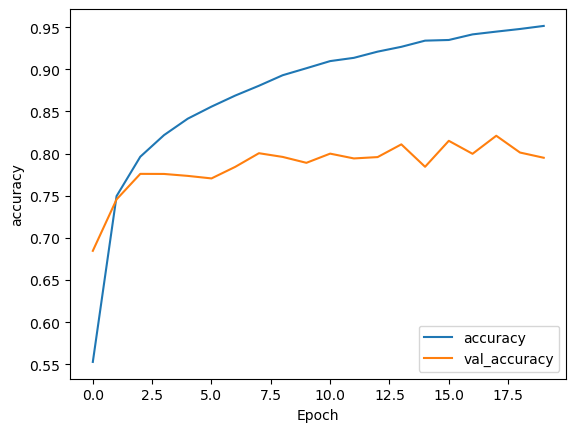

In [131]:
# Plot performance for "Accuracy" 
show_performance_curve(training_history,'accuracy','accuracy')

In [ ]:
# # Plot performance for "Precision" 
# show_performance_curve(training_history,'precision','precision')

313/313 [==============================] - 4s 11ms/step


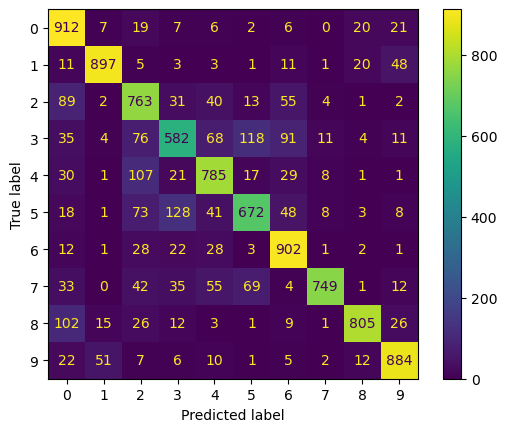

In [132]:
#Confusion matrix

test_predictions = model.predict(test_images)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(test_labels,axis=1)

cm = confusion_matrix(test_true_labels, test_predicted_labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()

In [133]:
#continue training
model.save('transfer-learning-20-epoch.h5')


In [138]:
#load model
loaded_model = tf.keras.models.load_model('transfer-learning-20-epoch.h5')

In [139]:
#continue training
training_history_1 = loaded_model.fit(x=train_images,
                             y=train_labels,
                             epochs=EPOCHS+10,
                             batch_size=BATCH_SIZE,
                             validation_data=(test_images, test_labels))

Epoch 1/30


2023-10-13 19:52:41.532611: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


391/391 [==============================] - 63s 130ms/step - loss: 0.5401 - accuracy: 0.8395 - val_loss: 0.5256 - val_accuracy: 0.8347
Epoch 2/30
391/391 [==============================] - 51s 130ms/step - loss: 0.4002 - accuracy: 0.8780 - val_loss: 0.5982 - val_accuracy: 0.8257
Epoch 3/30
391/391 [==============================] - 54s 139ms/step - loss: 0.3370 - accuracy: 0.8973 - val_loss: 0.6045 - val_accuracy: 0.8218
Epoch 4/30
391/391 [==============================] - 55s 140ms/step - loss: 0.2887 - accuracy: 0.9131 - val_loss: 0.6237 - val_accuracy: 0.8170
Epoch 5/30
391/391 [==============================] - 56s 142ms/step - loss: 0.2469 - accuracy: 0.9248 - val_loss: 0.6159 - val_accuracy: 0.8272
Epoch 6/30
391/391 [==============================] - 56s 143ms/step - loss: 0.2291 - accuracy: 0.9305 - val_loss: 0.5819 - val_accuracy: 0.8451
Epoch 7/30
391/391 [==============================] - 55s 141ms/step - loss: 0.2071 - accuracy: 0.9388 - val_loss: 0.6193 - val_accuracy: 0.8

In [ ]:
end = timer()
print("--- %s seconds ---" % (end-start))